In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns 




dataset = pd.read_csv('kc_house_data.csv')

In [2]:
#splitting x into elements and y into prediction 
columns_to_drop = ['id', 'date', 'price']
X = dataset.drop(columns=columns_to_drop, axis=1)
y = dataset['price']


In [3]:
#splitting the dataset into trainning and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [4]:
#handling the missing values by replacing it by their mean 
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [5]:
#rescalling the data by subtracting from its mean and divided by its standard deviation 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [6]:

selector = SelectKBest(f_regression, k='all')
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [7]:

model = LinearRegression()
model.fit(X_train_selected, y_train)

LinearRegression()

In [8]:

y_test_pred = model.predict(X_test_selected)

In [9]:

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Testing Mean Squared Error: {mse_test}')
print(f'Testing Mean Absolute Error: {mae_test}')
print(f'Testing R-squared: {r2_test}')
r2_percentage = r2_test * 100
print(f'Testing R-squared Percentage: {r2_percentage:.2f}%')


Testing Mean Squared Error: 35305762618.55043
Testing Mean Absolute Error: 124117.34836376477
Testing R-squared: 0.7183344057545193
Testing R-squared Percentage: 71.83%


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error



knn_regressor = KNeighborsRegressor()



In [11]:

param_grid = {'n_neighbors': [3, 5, 7, 9],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}

In [12]:

grid_search = GridSearchCV(knn_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [13]:

best_params = grid_search.best_params_

In [14]:

best_knn_regressor = KNeighborsRegressor(**best_params)
best_knn_regressor.fit(X_train_scaled, y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=9, weights='distance')

In [15]:

y_pred = best_knn_regressor.predict(X_test_scaled)

In [16]:


mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print(f"Root Mean Squared Error on Test Set: {rmse}")

Root Mean Squared Error on Test Set: 139149.83382301845


In [17]:

print("Best Hyperparameters:",best_params)

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


In [18]:

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"Mean Absolute Error on Test Set: {mae}")
print(f"R-squared on Test Set: {r2}")
print(f"R-squared on Test Set: {r2:.2%}")


Mean Absolute Error on Test Set: 77540.16647794165
R-squared on Test Set: 0.8455266418714567
R-squared on Test Set: 84.55%


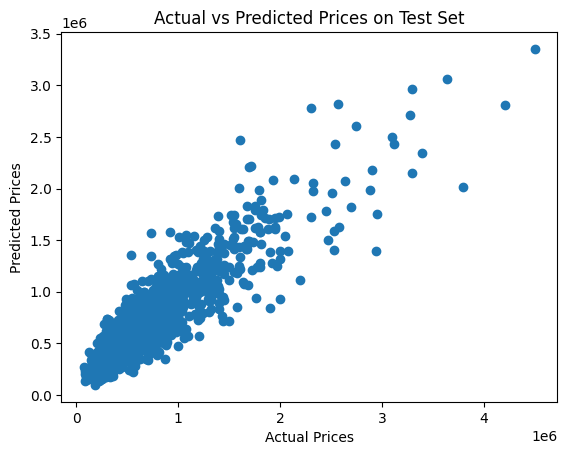

In [19]:

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices on Test Set")
plt.show()

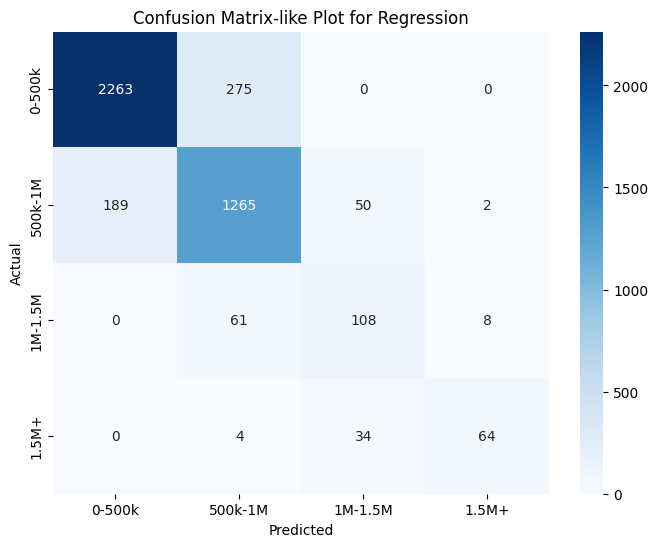

In [20]:


bins = [0, 500000, 1000000, 1500000, np.inf]
labels = ['0-500k', '500k-1M', '1M-1.5M', '1.5M+']


y_test_categories = pd.cut(y_test, bins=bins, labels=labels)
y_pred_categories = pd.cut(y_pred, bins=bins, labels=labels)


conf_matrix = confusion_matrix(y_test_categories, y_pred_categories, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix-like Plot for Regression')
plt.show()

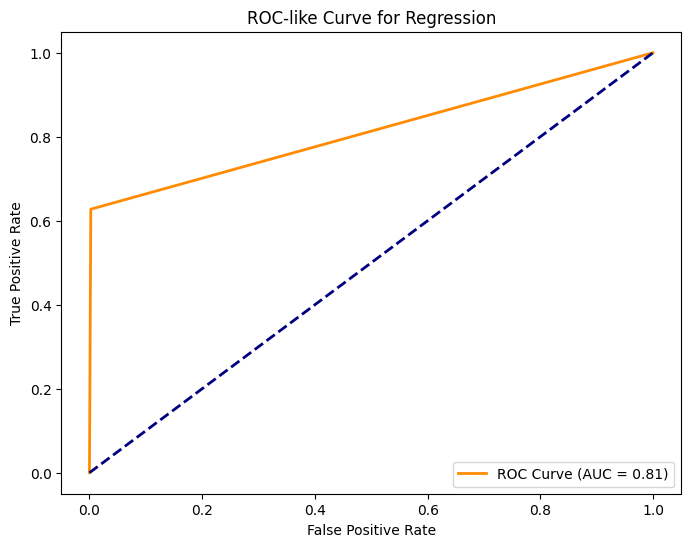

In [21]:


threshold = 1.5e6  

y_pred_binary = (y_pred > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

fpr, tpr, _ = roc_curve(y_test_binary, y_pred_binary)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-like Curve for Regression')
plt.legend(loc='lower right')
plt.show()

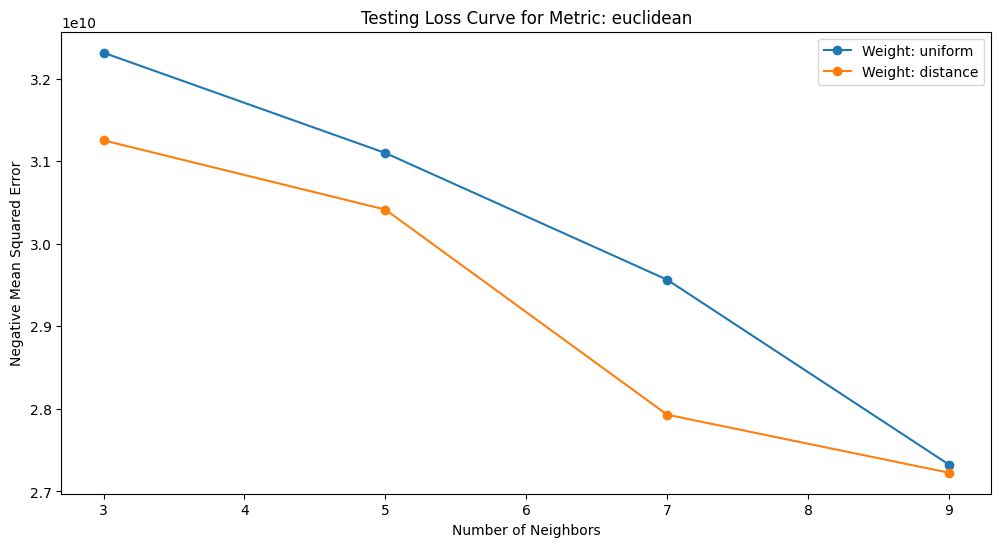

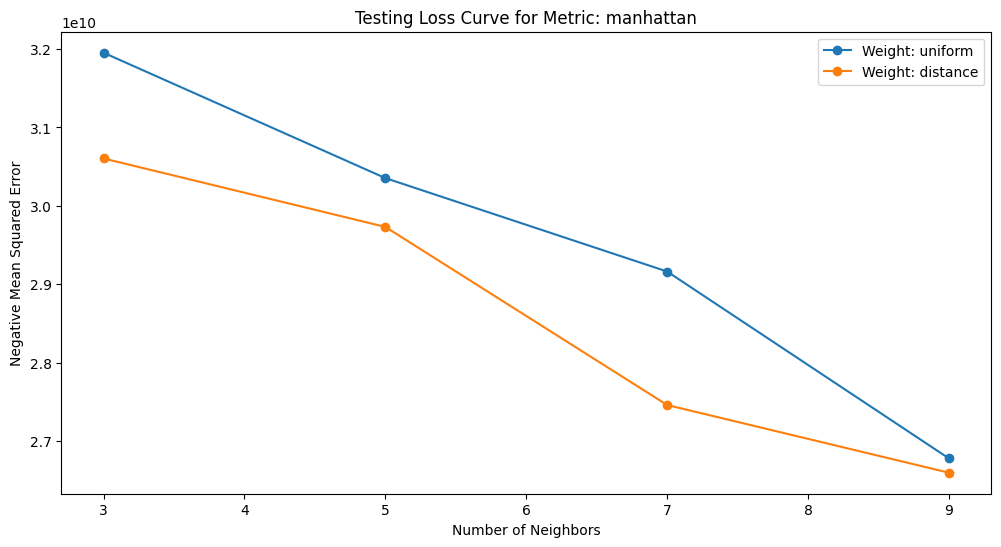

In [22]:



test_scores = -grid_search.cv_results_['mean_test_score']


scores_reshaped = test_scores.reshape(len(param_grid['n_neighbors']), len(param_grid['weights']), len(param_grid['metric']))


for i, metric in enumerate(param_grid['metric']):
    plt.figure(figsize=(12, 6))
    for j, weight in enumerate(param_grid['weights']):
        plt.plot(param_grid['n_neighbors'], scores_reshaped[:, j, i], marker='o', label=f'Weight: {weight}')

    plt.title(f'Testing Loss Curve for Metric: {metric}')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Negative Mean Squared Error')
    plt.legend()
    plt.show()